In [1]:
from generator import Generator
from critic import Critic
from dog_dataset import DogData

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch import optim

In [3]:
batchSize = 10

In [4]:
transform = transforms.Compose( [ transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) ] )
dogdata = DogData(transform)
dogloader = DataLoader(dogdata, shuffle=True, batch_size=batchSize, num_workers=3)

In [5]:
def get_critic_scores(real_batch, batchSize, critic, generator):
    generator.batchSize = batchSize
    critic.batchSize = batchSize
    #generate fake images
    randoBatch = torch.rand([batchSize, 100, 1, 1])
    generated = generator(randoBatch)
    #compute scores of both real and fake using the critic
    real_scores = critic(real_batch[0])
    gen_scores = critic(generated)
    return ( torch.sum(real_scores) , torch.sum(gen_scores) )

In [6]:
def get_generator_score(batchSize, critic, generator):
    generator.batchSize = batchSize
    #generate fake images
    randoBatch = torch.rand([batchSize, 100, 1, 1])
    generated = generator(randoBatch)
    #compute scores of generated using critic
    gen_scores = critic(generated)
    return torch.sum(gen_scores)

In [7]:
class WeightClipper(object):

    def __init__(self, frequency=5):
        self.frequency = frequency

    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = w.clamp(-0.01,0.01)
            module.weight.data = w

In [17]:
critic = Critic()
generator = Generator()
clipper = WeightClipper()
critic.apply(clipper)

Critic(
  (convBlocks): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fcBlocks): Sequential(
    (0): Seq

In [18]:
num_epochs = 50
critic_epochs = 5
gen_epochs = 1

In [19]:
criticOptim = optim.RMSprop(critic.parameters(), lr=0.00005, momentum=0)
genOptim = optim.RMSprop(generator.parameters(), lr=0.00005, momentum=0)

In [20]:
for epoch in range(num_epochs):
    print('Entering epoch yay: ' + str(epoch))
    realScore = 0.0 
    fakeScore = 0.0
    mainLoss = 0.0
    #critic training loop
    for batch_no, batch in enumerate(dogloader):
        print('Critic batch: ' + str(batch_no))
        scores = get_critic_scores(batch, batchSize, critic, generator)
        real_score = scores[0]
        gen_score = scores[1]
        #loss function
        loss = -( real_score - gen_score ) #+ 0.01 * ( torch.pow(real_score,2) + torch.pow(gen_score,2) ) #penalize for distance away from 0
        #some tracking of numbers here
        realScore += real_score.item()
        fakeScore += gen_score.item()
        mainLoss += loss.item()
        #optimize
        criticOptim.zero_grad()
        loss.backward()
        criticOptim.step()
        
        if (batch_no % critic_epochs == critic_epochs-1):
            break
    print(realScore)
    print(fakeScore)
    print(mainLoss)
    
    mainLoss = 0.0
    #generator training loop
    for gepoch in range(gen_epochs):
        print('Generator batch: ' + str(gepoch))
        gen_score = get_generator_score(batchSize, critic, generator)
        #loss function
        loss = -gen_score
        #tracking of numbers
        mainLoss += loss.item()
        #optimize
        genOptim.zero_grad()
        loss.backward()
        genOptim.step()
    print(mainLoss)

Entering epoch yay: 0
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
Critic batch: 4
-5.648809909820557
-5.650681972503662
-0.0018720626831054688
Generator batch: 0
1.1305409669876099
Entering epoch yay: 1
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
Critic batch: 4
-5.647359848022461
-5.654306173324585
-0.0069463253021240234
Generator batch: 0
1.1318895816802979
Entering epoch yay: 2
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
Critic batch: 4
-5.647092700004578
-5.67496919631958
-0.02787649631500244
Generator batch: 0
1.1404523849487305
Entering epoch yay: 3
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
Critic batch: 4
-5.64725124835968
-5.713114857673645
-0.06586360931396484
Generator batch: 0
1.1485236883163452
Entering epoch yay: 4
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
Critic batch: 4
-5.64720892906189
-5.747017979621887
-0.09980905055999756
Generator batch: 0
1.1526809930801392
Ente

Critic batch: 1
Critic batch: 2
Critic batch: 3
Critic batch: 4
-5.647141695022583
-6.198517799377441
-0.5513761043548584
Generator batch: 0
1.2489819526672363
Entering epoch yay: 42
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
Critic batch: 4
-5.647189617156982
-6.203593969345093
-0.5564043521881104
Generator batch: 0
1.2519758939743042
Entering epoch yay: 43
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
Critic batch: 4
-5.647241830825806
-6.2201313972473145
-0.5728895664215088
Generator batch: 0
1.246422529220581
Entering epoch yay: 44
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
Critic batch: 4
-5.647148251533508
-6.1910998821258545
-0.5439516305923462
Generator batch: 0
1.2502671480178833
Entering epoch yay: 45
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
Critic batch: 4
-5.647359132766724
-6.218554615974426
-0.5711954832077026
Generator batch: 0
1.2508472204208374
Entering epoch yay: 46
Critic batch: 0
Crit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


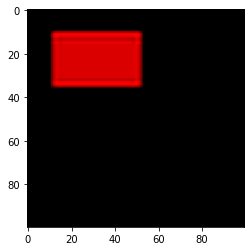

tensor([[-0.1273]], grad_fn=<AddmmBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



tensor([[-0.2023]], grad_fn=<AddmmBackward>)


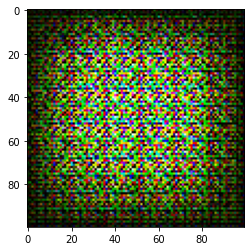

In [21]:
import matplotlib.pyplot as plt
plt.imshow(dogdata[0][0].permute(1,2,0))
plt.show()

critic.batchSize = 1
critic.eval()
print(critic(dogdata[800][0].unsqueeze(0)))
rando = torch.rand([1, 100, 1, 1])
print(critic(generator(rando)))

gen = generator(rando)
plt.imshow(gen[0].permute(1,2,0).detach().numpy())
plt.show()